In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Lambda
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import to_categorical

### Решить задачу многоклассовой классификации с помощью многослойной нейронной сети, состоящей из полносвязных слоев.

In [2]:
# загружаем данные и разбиваем их на составляющие
train = pd.read_csv("./train.csv")
y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

In [3]:

X_train = normalize(X_train.astype('float32'), axis=1)

# Из файла информацию о изображения с цифрами мы получили в виде одномерных векторов из 784 значений
# Переформируем все данные в трехмерные матрицы 28x28x1.
# Keras требует дополнительное измерение в конце, для каналов. 
# Если бы это были RGB-изображения, то было бы 3 канала, но поскольку у нас "черно-белое" изображение, мы указываем 1 серый канал.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

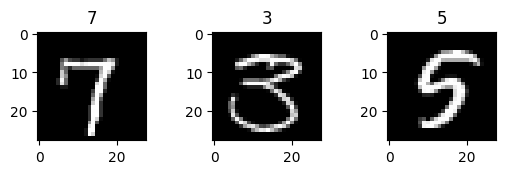

In [4]:
# убедимся, что все ок, выведем сами тестовые изображения и соответствующие им цифры 
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

Стандартизация особенностей - это важный этап предварительной обработки. Он используется для центрирования данных вокруг нулевого среднего и единичной дисперсии.

In [5]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)
def standardize(x): 
    return (x-mean_px)/std_px

Метки в данном случае представлены целыми числами от 0 до 9. 
Нам нужно применить one-hot encoding, чтобы преобразовать эти one-hot числовой массив (например: 2 -> [0,0,1,0,0,0,0,0,0,0,0]).

In [6]:
print(f"{y_train[0]} преобрауется в ")
y_train = to_categorical(y_train, num_classes = 10)
# Пример:
print(y_train[0])

1 преобрауется в 
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [8]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [9]:
model = Sequential()
model.add(Lambda(standardize,input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(128, activation='relu')),
model.add(Dense(128, activation='relu')),
model.add(Dense(10, activation='softmax'))

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Определим callback для сохранения весов на каждой этапе обучения
# Это понадобится позже для определения параметров, при которых точность максимальна
checkpoint_callback = ModelCheckpoint(
    filepath='weights.{epoch:02d}.h5',
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)

history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=29, 
                    verbose=1,
                    validation_data=(X_test, y_test), callbacks=[checkpoint_callback])

loss, accuracy = model.evaluate(X_test, y_test)

print(f"Final loss: {loss}")
print(f"Final accuracy: {accuracy}")


Epoch 1/29


2096/2100 [============================>.] - ETA: 0s - loss: 0.4829 - accuracy: 0.8441
Epoch 1: saving model to weights.01.h5
2100/2100 [==============================] - 15s 7ms/step - loss: 0.4825 - accuracy: 0.8442 - val_loss: 0.2201 - val_accuracy: 0.9313
Epoch 2/29
2096/2100 [============================>.] - ETA: 0s - loss: 0.2556 - accuracy: 0.9195
Epoch 2: saving model to weights.02.h5
2100/2100 [==============================] - 13s 6ms/step - loss: 0.2557 - accuracy: 0.9196 - val_loss: 0.1445 - val_accuracy: 0.9536
Epoch 3/29
2096/2100 [============================>.] - ETA: 0s - loss: 0.2213 - accuracy: 0.9308
Epoch 3: saving model to weights.03.h5
2100/2100 [==============================] - 15s 7ms/step - loss: 0.2218 - accuracy: 0.9307 - val_loss: 0.1596 - val_accuracy: 0.9510
Epoch 4/29
2100/2100 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9399
Epoch 4: saving model to weights.04.h5
2100/2100 [==============================] - 13s

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Посмотрим, как происходило изменение точности на каждой из эпох

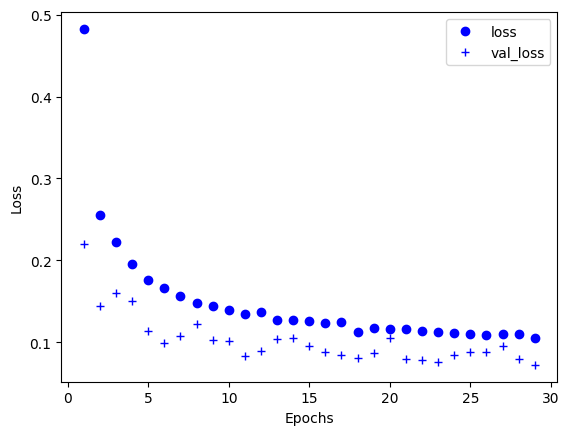

In [13]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo')
plt.plot(epochs, val_loss_values, 'b+')
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

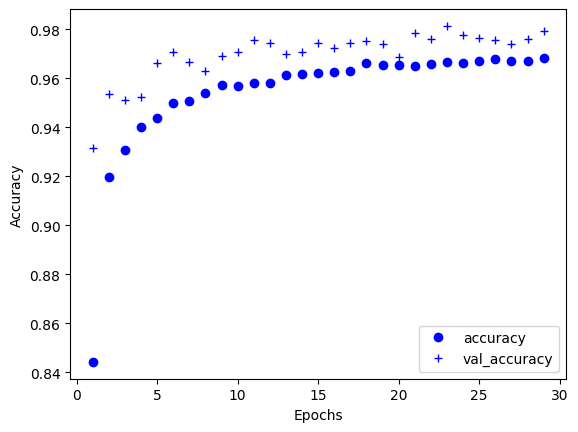

In [14]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

### Вычислить градиент целевой функции по обучаемым параметрам нейронной сети, сравнить полученные значения со значениями, вычисленными с помощью библиотечных функций

In [15]:
# Найдем эпоху с наивысшей точностью валидации
best_epoch = np.argmax(history.history['val_accuracy'])
best_accuracy = history.history['val_accuracy'][best_epoch]

# Получим веса модели для этой эпохи из файла, сохраненного ранее на этапе обучения
model.load_weights(f'weights.{best_epoch+1:02d}.h5')

# Получим параметры модели для лучшей эпохи
best_parameters = model.get_weights()

print(f"Best accuracy: {best_accuracy}")
print("Best params:")
for layer_param in best_parameters:
    print(layer_param)

Best accuracy: 0.9813095331192017
Best params:
[[-0.04220533  0.18742411 -0.14756899 ... -0.01708057  0.1183227
   0.17657517]
 [ 0.02343066  0.12704588 -0.17909186 ...  0.03032963  0.03593529
   0.07722642]
 [ 0.06052176  0.17553481 -0.11769428 ...  0.07179723  0.02911661
   0.11864807]
 ...
 [ 0.01304426  0.07974745 -0.09822937 ... -0.07474518  0.01332953
   0.0781544 ]
 [-0.04650022  0.18392773 -0.09008701 ... -0.02937578 -0.01390326
   0.14088707]
 [ 0.02064295  0.15368721 -0.14459725 ...  0.07614125  0.09210829
   0.09907603]]
[-0.03059397 -0.11160898  0.10550868 -0.19308043 -0.09763703 -0.13176575
 -0.07652689  0.06605405 -0.04883838  0.00553885 -0.09068472  0.06433117
 -0.11792408 -0.07643215 -0.04755628 -0.08748143  0.04514018 -0.19209485
 -0.21552597 -0.07540876 -0.08458669 -0.05478548 -0.10911197 -0.07660513
  0.03004547  0.00243603  0.07220473 -0.05557925 -0.15863356 -0.11089264
 -0.09416723 -0.17974415 -0.27016288 -0.11159208 -0.05874808 -0.11151635
  0.1654178  -0.0603856 

### Определить параметры нейронной сети, при которых точность классификации максимальна

Чтобы определить параметры нейронной сети, при которых точность классификации максимальна, мы
- должны проанализировать объект history, возвращаемый методом fit(), который содержит историю обучения, включая значения точности для каждой эпохи;
- найти эпоху с лучшей точностью проверки;
- по мере обучения модели мы сохраняем веса, полученные на каждой эпохе, в отдельный файл. Загрузим веса из файла соответсвующего эпохе с лучшей точностью;
- используем model.get_weights() для получения параметров (весов и смещений) модели в лучшую эпоху. Мы перебираем параметры и выводим их формы, чтобы проверить размеры параметров каждого слоя.

In [16]:
# Найдем эпоху с наивысшей точностью валидации
best_epoch = np.argmax(history.history['val_accuracy'])
best_accuracy = history.history['val_accuracy'][best_epoch]

# Получим веса модели для этой эпохи из файла, сохраненного ранее на этапе обучения
model.load_weights(f'weights.{best_epoch+1:02d}.h5')

# Получим параметры модели для лучшей эпохи
best_parameters = model.get_weights()

print(f"Best accuracy: {best_accuracy}")
print("Best params:")
for layer_param in best_parameters:
    print(layer_param)

Best accuracy: 0.9813095331192017
Best params:
[[-0.04220533  0.18742411 -0.14756899 ... -0.01708057  0.1183227
   0.17657517]
 [ 0.02343066  0.12704588 -0.17909186 ...  0.03032963  0.03593529
   0.07722642]
 [ 0.06052176  0.17553481 -0.11769428 ...  0.07179723  0.02911661
   0.11864807]
 ...
 [ 0.01304426  0.07974745 -0.09822937 ... -0.07474518  0.01332953
   0.0781544 ]
 [-0.04650022  0.18392773 -0.09008701 ... -0.02937578 -0.01390326
   0.14088707]
 [ 0.02064295  0.15368721 -0.14459725 ...  0.07614125  0.09210829
   0.09907603]]
[-0.03059397 -0.11160898  0.10550868 -0.19308043 -0.09763703 -0.13176575
 -0.07652689  0.06605405 -0.04883838  0.00553885 -0.09068472  0.06433117
 -0.11792408 -0.07643215 -0.04755628 -0.08748143  0.04514018 -0.19209485
 -0.21552597 -0.07540876 -0.08458669 -0.05478548 -0.10911197 -0.07660513
  0.03004547  0.00243603  0.07220473 -0.05557925 -0.15863356 -0.11089264
 -0.09416723 -0.17974415 -0.27016288 -0.11159208 -0.05874808 -0.11151635
  0.1654178  -0.0603856 

In [17]:
print("Описание модели:")
model.summary()

Описание модели:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 28, 28, 1)         0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (462.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________